# Read data
Read both affine params and points, the normal datagen pipeline for training should do. 

In [22]:
from utils.utils0 import *
from utils.utils1 import *
from utils.utils1 import ModelParams, model_loader, print_summary#, test_repeat
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


In [23]:
model_params = ModelParams(dataset=2, sup=1)
train_dataset = datagen(model_params.dataset, True, model_params.sup)
test_dataset = datagen(model_params.dataset, False, model_params.sup)

Model name:  dataset2_sup1_image1_points0_loss_image0
Model code:  21100_0.001_0_10_1
Model params:  {'dataset': 2, 'sup': 1, 'image': 1, 'points': 0, 'loss_image_case': 0, 'loss_image': MSELoss(), 'loss_affine': <utils.utils1.loss_affine object at 0x7f8a1d31da90>, 'learning_rate': 0.001, 'decay_rate': 0.96, 'start_epoch': 0, 'num_epochs': 10, 'batch_size': 1, 'model_name': 'dataset2_sup1_image1_points0_loss_image0'}


In [24]:
# draw a pair of images from the test set
outputs = list(train_dataset)[0]

In [25]:
for output in outputs:
    print(output.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 3])
torch.Size([1, 47, 2])
torch.Size([1, 47, 2])
torch.Size([1, 47, 2])


# Define NN model
- Input: affine parms (2x3), original points (2x1)
- Output: predicted transformed points (2x1)
- Groundtruth: true transformed points (2x1)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

In [27]:
class AffineTransformationNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(AffineTransformationNetwork, self).__init__()

        # Check if hidden_sizes is empty
        if not hidden_sizes:
            self.hidden_layers = nn.ModuleList([])
            self.fc = nn.Linear(input_size, output_size)
        else:
            layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
            for i in range(1, len(hidden_sizes)):
                layers += [nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]), nn.ReLU()]
            layers += [nn.Linear(hidden_sizes[-1], output_size)]
            self.hidden_layers = nn.ModuleList(layers)

    def forward(self, affine_matrix, point):
        # Flatten and concatenate the input matrices
        input_data = torch.cat((affine_matrix, point))

        # Pass the input through hidden layers
        for layer in self.hidden_layers:
            input_data = layer(input_data)

        # Reshape the output to (2x1)
        transformed_point = input_data#.view(2)

        return transformed_point

# Example: Create an instance of the neural network with 2 hidden layers and 64 neurons in each hidden layer
input_size = 8  # Affine matrix (2x3) + Point (2x1)
hidden_sizes = [64, 64]
output_size = 2  # Transformed point (2x1)

model = AffineTransformationNetwork(input_size, hidden_sizes, output_size)
print(model)
model.to(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
parameters = list(model.parameters())
print(f'Number of parameters: {len(parameters)}')
# print(f'Parameters: {parameters}')
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1200, gamma=0.05)



AffineTransformationNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)
Number of parameters: 6


## Training

In [28]:
train_dataset_new = []
# loop through all items in the train_dataset 
# and modify the input and output as described above
train_bar = tqdm(train_dataset, desc='Training')
# Loop over all training examples
for i, (source_img, target_img, affine_params, \
        matches1, matches2, matches1_2) in enumerate(train_bar):
    for j in range(matches1.shape[1]):
        train_dataset_new.append((torch.cat((affine_params.view(-1), matches1[0][j])), matches2[0][j]))
        if j > 5:
            break   

test_dataset_new = []
# loop through all items in the train_dataset 
# and modify the input and output as described above
test_bar = tqdm(test_dataset, desc='Testing')
# Loop over all training examples
for i, (source_img, target_img, affine_params, \
        matches1, matches2, matches1_2) in enumerate(test_bar):
    for j in range(matches1.shape[1]):
        test_dataset_new.append((torch.cat((affine_params.view(-1), matches1[0][j])), matches2[0][j]))
        if j > 2:
            break   

Testing: 100%|██████████| 100/100 [00:01<00:00, 83.70it/s]


In [29]:
# Create empty list to store epoch number, train loss and validation loss
epoch_loss_list = []
running_loss_list = []
print('Seed:', torch.seed())

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    
    # optimizer.zero_grad()
    running_loss = 0.0
    

    train_bar = tqdm(train_dataset_new, desc='Training Epoch %d/%d' % (epoch+1, epochs))
    # Loop over all training examples
    for i, (input, matches1_2) in enumerate(train_bar):
        optimizer.zero_grad()
        # Set the inputs and labels to the training device
        # source_img = source_img.to(device)
        # target_img = target_img.to(device)
        affine_params = input[:6].to(device)
        matches1 = input[6:].to(device)
        # matches2 = matches2.to(device)
        matches1_2 = matches1_2.to(device)

        # optimizer.zero_grad()
        # for j in range(matches1.shape[1]):
        # Forward pass
        predicted_points = model(affine_params, matches1)

        # Compute the loss
        loss = criterion(predicted_points, matches1_2)

        running_loss += loss.item()
        
        train_bar.set_postfix({'loss': running_loss / (i+1)})

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    scheduler.step()
    epoch_loss_list.append(running_loss / len(train_dataset))
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_dataset_new)}')

    # Validation loop
    model.eval()

    # Create empty list to store validation loss
    val_loss_list = []
    val_running_loss = 0.0

    test_bar = tqdm(test_dataset_new, desc='Testing Epoch %d/%d' % (epoch+1, epochs))
    # Loop over all validation examples
    for i, (input, matches1_2) in enumerate(test_bar):
        # Set the inputs and labels to the validation device
        # source_img = source_img.to(device)
        # target_img = target_img.to(device)
        affine_params = input[:6].to(device)
        matches1 = input[6:].to(device)
        # matches2 = matches2.to(device)
        matches1_2 = matches1_2.to(device)

        # Forward pass
        predicted_points = model(affine_params, matches1)

        # Compute the loss
        loss = criterion(predicted_points, matches1_2)

        val_running_loss += loss.item()
        test_bar.set_postfix({'loss': val_running_loss / (i+1)})

    val_loss_list.append(val_running_loss / len(test_dataset_new))
    print(f'Epoch [{epoch + 1}/{epochs}], Val Loss: {val_running_loss / len(test_dataset_new)}')

    # Save the model if the validation loss is the lowest we've seen so far
    if val_loss_list[-1] == min(val_loss_list):
        torch.save(model.state_dict(), f'trained_models/affine_NN_{epoch:03d}.pth')
        print('Model saved')

    

Seed: 13951365752222412541


Training Epoch 1/20: 100%|██████████| 2400/2400 [00:19<00:00, 121.76it/s, loss=583]   


Epoch [1/20], Loss: 583.3439969781911


Training Epoch 2/20: 100%|██████████| 2400/2400 [00:18<00:00, 133.12it/s, loss=312]


Epoch [2/20], Loss: 312.34412935246405


Training Epoch 3/20: 100%|██████████| 2400/2400 [00:17<00:00, 136.46it/s, loss=306]


Epoch [3/20], Loss: 305.76847656498353


Training Epoch 4/20: 100%|██████████| 2400/2400 [00:17<00:00, 137.36it/s, loss=300]


Epoch [4/20], Loss: 300.0825859309919


Training Epoch 5/20: 100%|██████████| 2400/2400 [00:18<00:00, 132.06it/s, loss=295]


Epoch [5/20], Loss: 295.07854200551907


Training Epoch 6/20: 100%|██████████| 2400/2400 [00:18<00:00, 128.59it/s, loss=293]


Epoch [6/20], Loss: 293.029749269085


Training Epoch 7/20: 100%|██████████| 2400/2400 [00:18<00:00, 130.28it/s, loss=289]


Epoch [7/20], Loss: 289.04564103196066


Training Epoch 8/20: 100%|██████████| 2400/2400 [00:18<00:00, 128.13it/s, loss=286]


Epoch [8/20], Loss: 286.4518131517929


Training Epoch 9/20: 100%|██████████| 2400/2400 [00:18<00:00, 128.10it/s, loss=286]


Epoch [9/20], Loss: 285.6396338535876


Training Epoch 10/20: 100%|██████████| 2400/2400 [00:18<00:00, 128.94it/s, loss=282]


Epoch [10/20], Loss: 282.31545614516983


Training Epoch 11/20: 100%|██████████| 2400/2400 [00:17<00:00, 134.36it/s, loss=280]


Epoch [11/20], Loss: 279.9257830407036


Training Epoch 12/20: 100%|██████████| 2400/2400 [00:18<00:00, 128.46it/s, loss=278]


Epoch [12/20], Loss: 277.9123531956598


Training Epoch 13/20: 100%|██████████| 2400/2400 [00:18<00:00, 133.00it/s, loss=276]


Epoch [13/20], Loss: 276.4506436477353


Training Epoch 14/20: 100%|██████████| 2400/2400 [00:18<00:00, 132.77it/s, loss=275]


Epoch [14/20], Loss: 275.4055564340443


Training Epoch 15/20: 100%|██████████| 2400/2400 [00:17<00:00, 133.34it/s, loss=274]


Epoch [15/20], Loss: 274.00020019737696


Training Epoch 16/20: 100%|██████████| 2400/2400 [00:18<00:00, 133.13it/s, loss=272]


Epoch [16/20], Loss: 272.22240269750125


Training Epoch 17/20: 100%|██████████| 2400/2400 [00:18<00:00, 132.60it/s, loss=271]


Epoch [17/20], Loss: 270.7990274061573


Training Epoch 18/20: 100%|██████████| 2400/2400 [00:18<00:00, 132.94it/s, loss=271]


Epoch [18/20], Loss: 270.7168908474284


Training Epoch 19/20: 100%|██████████| 2400/2400 [00:18<00:00, 133.19it/s, loss=269]


Epoch [19/20], Loss: 268.94441433472247


Training Epoch 20/20: 100%|██████████| 2400/2400 [00:17<00:00, 135.03it/s, loss=268]

Epoch [20/20], Loss: 267.746869375091


In [33]:
# save model to file train_model/affine_transformation_network.pt
torch.save(model.state_dict(), 'trained_models/affine_NN.pth')

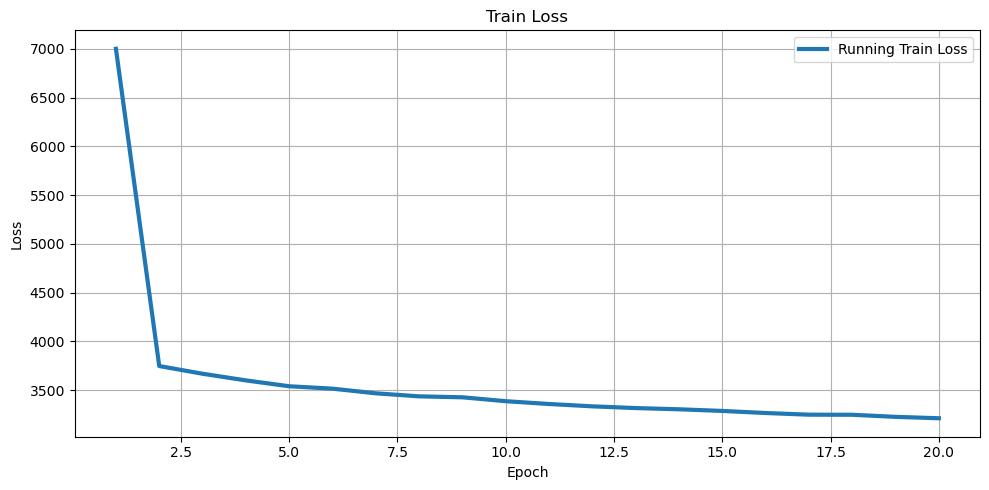

In [50]:
 # Plot train loss and validation loss against epoch number
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), epoch_loss_list, label='Running Train Loss', linewidth=3)
plt.plot(range(1, epochs+1), val_loss_list, label='Running Validation Loss', linewidth=3)
plt.title('Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.yscale('log')
plt.tight_layout()

# Save plot
# signaturebar_gray(fig, f'{model_params.get_model_code()} - epoch{model_params.num_epochs} - {timestamp}')
# fig.savefig(save_plot_name)

In [52]:
model.eval()

test_bar = tqdm(test_dataset_new, desc='Testing')
for i, (input, matches1_2) in enumerate(test_bar):
    # Set the inputs and labels to the training device
    # source_img = source_img.to(device)
    # target_img = target_img.to(device)
    affine_params = input[:6].to(device)
    matches1 = input[6:].to(device)
    # matches2 = matches2.to(device)
    matches1_2 = matches1_2.to(device)

    # optimizer.zero_grad()
    # for j in range(matches1.shape[1]):
    # Forward pass
    predicted_points = model(affine_params, matches1)

    # # Compute the loss
    # loss = criterion(predicted_points, matches1_2)

    # running_loss += loss.item()

    test_bar.set_postfix({'loss': running_loss / (i+1)})
    print(f'True: {matches1_2}, Predicted: {predicted_points}')
    if i > 10:
        break

Testing:   1%|          | 8/1200 [00:00<00:30, 38.93it/s, loss=6.43e+4]

True: tensor([ 79., 140.], device='cuda:0'), Predicted: tensor([ 74.0484, 134.3428], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([98., 68.], device='cuda:0'), Predicted: tensor([89.7310, 74.6381], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([221., 132.], device='cuda:0'), Predicted: tensor([192.4877, 125.0214], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([72., 96.], device='cuda:0'), Predicted: tensor([69.6305, 98.1659], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([ 50., 132.], device='cuda:0'), Predicted: tensor([ 45.0721, 126.0813], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([ 33., 105.], device='cuda:0'), Predicted: tensor([ 32.3587, 104.0244], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([49., 59.], device='cuda:0'), Predicted: tensor([50.5610, 69.4127], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([247.,  38.], device='cuda:0'), Predicted: tensor([207.7063,  42.7250], device='cuda:0', grad_fn=<ViewBackward

Testing:   1%|          | 11/1200 [00:00<00:29, 40.34it/s, loss=5.35e+4]

True: tensor([ 59., 194.], device='cuda:0'), Predicted: tensor([ 53.1285, 175.2049], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([ 57., 214.], device='cuda:0'), Predicted: tensor([ 53.8105, 192.5636], device='cuda:0', grad_fn=<ViewBackward0>)
True: tensor([222., 114.], device='cuda:0'), Predicted: tensor([190.5564, 110.0999], device='cuda:0', grad_fn=<ViewBackward0>)


In [30]:
# Example usage after training
sample_input = list(test_dataset)[0].to(device)
transformed_point = model(sample_input[2], sample_input[3])
print("Transformed Point:", transformed_point)
print("Ground Truth:", sample_input[4])

AttributeError: 'list' object has no attribute 'to'